In [2]:
#import sys
#sys.path.insert(0,"/workspace/bt")

import yfinance as yf
import matplotlib.pyplot as plt
from strategy import *

%matplotlib inline

In [3]:
# 투자자산
tickers = ['TQQQ','TMF']
# 비교자산+안전자산
dualtickers = ['BND','BIL']

# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1
resample_monthly = False

In [4]:
data = yf.download(tickers+dualtickers)['Adj Close']
data = data[tickers+dualtickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()

if resample_monthly:
    assets = assets.resample('M').last().dropna()
    lag = 0
    
start_day = assets.index.min() + pd.DateOffset(months=12) - pd.DateOffset(days=1)
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  4 of 4 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BND 2007-04-10 00:00:00
BIL 2007-05-30 00:00:00
asset 
                  TQQQ        TMF        BND        BIL
Date                                                  
2010-02-11   0.431471   6.695425  55.449631  86.560013
2010-02-12   0.433238   6.771190  55.526741  86.560013
2010-02-16   0.450019   6.831800  55.596771  86.560013
2010-02-17   0.457656   6.613165  55.470654  86.503387
2010-02-18   0.466332   6.500601  55.393543  86.541153
...               ...        ...        ...        ...
2022-12-05  22.230000   9.230000  72.919998  91.449997
2022-12-06  20.820000   9.590000  73.160004  91.480003
2022-12-07  20.570000  10.230000  73.800003  91.480003
2022-12-08  21.299999  10.160000  73.589996  91.540001
2022-12-09  20.889999   9.380000  73.160004  91.529999

[3231 rows x 4 columns]
start day :  2011-02-10 00:00:00


In [6]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

# 벤치마크 수익율
benchmark = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
report = bt.run(benchmark)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2011-02-10
End                  2022-12-09
Risk-free rate       0.00%

Total Return         2165.31%
Daily Sharpe         0.74
Daily Sortino        1.16
CAGR                 30.19%
Max Drawdown         -80.64%
Calmar Ratio         0.37

MTD                  -11.33%
3m                   -29.99%
6m                   -30.34%
YTD                  -74.88%
1Y                   -74.28%
3Y (ann.)            3.04%
5Y (ann.)            12.63%
10Y (ann.)           34.73%
Since Incep. (ann.)  30.19%

Daily Sharpe         0.74
Daily Sortino        1.16
Daily Mean (ann.)    45.95%
Daily Vol (ann.)     62.01%
Daily Skew           -0.40
Daily Kurt           6.39
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.77
Monthly Sortino      1.45
Monthly Mean (ann.)  41.09%
Monthly Vol (ann.)   53.31%
Monthly Skew         -0.14
Monthly Kurt         0.27
Best Month           46.45%
W

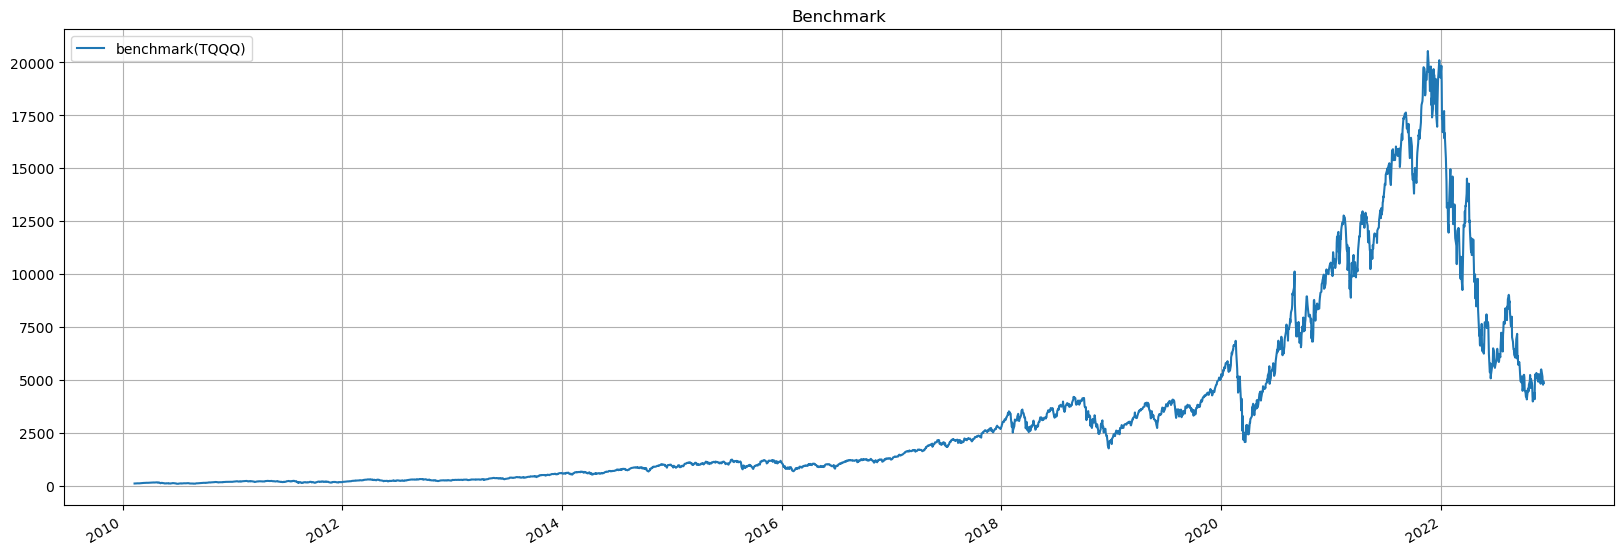

In [7]:
report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(report.prices[start_day:].calc_stats().display())

In [20]:
report.backtests['benchmark(TQQQ)'].stats.drawdown_details

,Start,End,Length,drawdown
0,2010-02-22 00:00:00,2010-03-01 00:00:00,7,-0.045788
1,2010-03-15 00:00:00,2010-03-16 00:00:00,1,-0.006734
2,2010-03-19 00:00:00,2010-03-22 00:00:00,3,-0.017689
3,2010-03-24 00:00:00,2010-03-30 00:00:00,6,-0.020396
4,2010-03-31 00:00:00,2010-04-05 00:00:00,5,-0.015432
...,...,...,...,...
165,2021-08-31 00:00:00,2021-09-01 00:00:00,1,-0.002802
166,2021-09-02 00:00:00,2021-09-03 00:00:00,1,-0.001397
167,2021-09-08 00:00:00,2021-10-28 00:00:00,50,-0.217203
168,2021-11-08 00:00:00,2021-11-18 00:00:00,10,-0.067366


In [21]:
report.backtests['benchmark(TQQQ)'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
169,2021-11-22 00:00:00,2022-12-09 00:00:00,382,-0.806368
138,2020-02-20 00:00:00,2020-07-10 00:00:00,141,-0.699221
124,2018-08-30 00:00:00,2019-11-04 00:00:00,431,-0.580828
78,2015-07-21 00:00:00,2016-09-22 00:00:00,429,-0.445369
20,2011-07-25 00:00:00,2012-02-08 00:00:00,198,-0.439113
7,2010-04-26 00:00:00,2010-10-25 00:00:00,182,-0.430919
144,2020-09-03 00:00:00,2020-12-17 00:00:00,105,-0.35375
29,2012-04-04 00:00:00,2012-09-06 00:00:00,155,-0.319383
31,2012-09-20 00:00:00,2013-04-30 00:00:00,222,-0.31895
152,2021-02-16 00:00:00,2021-04-13 00:00:00,56,-0.304332


In [23]:
report.backtests['benchmark(TQQQ)'].stats.drawdown_details.sort_values(by='Length', ascending=False).head(20)

,Start,End,Length,drawdown
124,2018-08-30 00:00:00,2019-11-04 00:00:00,431,-0.580828
78,2015-07-21 00:00:00,2016-09-22 00:00:00,429,-0.445369
169,2021-11-22 00:00:00,2022-12-09 00:00:00,382,-0.806368
31,2012-09-20 00:00:00,2013-04-30 00:00:00,222,-0.31895
20,2011-07-25 00:00:00,2012-02-08 00:00:00,198,-0.439113
7,2010-04-26 00:00:00,2010-10-25 00:00:00,182,-0.430919
29,2012-04-04 00:00:00,2012-09-06 00:00:00,155,-0.319383
138,2020-02-20 00:00:00,2020-07-10 00:00:00,141,-0.699221
144,2020-09-03 00:00:00,2020-12-17 00:00:00,105,-0.35375
119,2018-03-13 00:00:00,2018-06-14 00:00:00,93,-0.296761


In [34]:
report.prices.to_drawdown_series()

,benchmark(TQQQ)
2010-02-10,0.000000
2010-02-11,0.000000
2010-02-12,0.000000
2010-02-16,0.000000
2010-02-17,0.000000
...,...
2022-12-05,-0.749012
2022-12-06,-0.764932
2022-12-07,-0.767754
2022-12-08,-0.759512
